# Full Neural Network Setup

In [1]:
base_path = '/content/drive'
nb_path = base_path + '/MyDrive/PTR-augur/notebooks'

In [2]:
from google.colab import drive
drive.mount(base_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# library dependencies
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import lzma
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import keras
from keras import layers
import tensorflow as tf
# import keras_tuner
import math
import time

In [4]:
# method to store data as serialized binary structure lzma compressed
def can_pickles(data, filename):
    with lzma.LZMAFile(filename, 'wb') as f:
        pickle.dump(data, f, pickle.DEFAULT_PROTOCOL)

# method to retrieve data from a compressed pickle file (created with the method above)
def uncan_pickles(filename):
    with lzma.LZMAFile(filename, 'rb') as f:
        return pickle.load(f)

In [5]:
# helper method to create a valid dataset
# padded batches from ragged tensors are not supported (yet)
# it needs a work around creating a uniform tensor
# idea from : https://github.com/tensorflow/tensorflow/issues/39163
def reformat(data, label):
    return data, label

# method to create a TF dataset
def create_dataset(X1_np_array, X2_np_array, y_np_array, batch_size=32, sort=False, step_size=5):
    # sort the arrays
    if sort == True:
        # build an array containing the sequence lengths
        sequence_lengths = list(map(lambda x: len(x), X1_np_array))
        # sort the array but only get the indices
        sorted_indices = np.argsort(sequence_lengths)
        # now sort the X and y train arrays according to the sorted indicds
        X1_np_array = X1_np_array[sorted_indices]
        X2_np_array = X2_np_array[sorted_indices]
        y_np_array = y_np_array[sorted_indices]

    # create ragged tensor from in-homogeneous array
    # using .constant is incredibly slow, even slower with parameters
    # ie. 100 samples take 7 seconds, with parameters it takes 11 seconds
    # using the following method that seems nuts it's a speedup for the previous example to 0.02 seconds
    # X_tensor = tf.ragged.constant(X1_np_array, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
    # https://github.com/tensorflow/tensorflow/issues/47853
    # with tf.device('/device:cpu:0'):
    X_tensor = tf.RaggedTensor.from_row_lengths(
        values=tf.concat(X1_np_array.tolist(), axis=0),
        row_lengths=[len(a) for a in X1_np_array]
    )

    # hack to work around a GPU out of memory problem
    # X_tensor = None
    # step_size = step_size
    # steps = math.ceil(len(X1_np_array) / step_size)
    # for i in range(steps):
    #   start = step_size * i
    #   stop = step_size * (i + 1)
    #   if stop > len(X1_np_array): stop = len(X1_np_array)
    #   # print(f'start {start} - stop {stop}')

    #   sub_X1_np_array = X1_np_array[start:stop]

    #   foo = tf.RaggedTensor.from_row_lengths(
    #       values=tf.concat(sub_X1_np_array.tolist(), axis=0),
    #       row_lengths=[len(a) for a in sub_X1_np_array]
    #   )

    #   if X_tensor == None:
    #     X_tensor = foo
    #   else:
    #     X_tensor = tf.concat([X_tensor, foo], axis=0)


    # create dataset
    ds = tf.data.Dataset.from_tensor_slices(({'inputs_1': X_tensor, 'inputs_2': X2_np_array}, y_np_array))

    # create a dataset of dense tensors
    ds = ds.map(reformat)

    # apply padded batching to the dataset
    ds = ds.padded_batch(batch_size)

    return ds

In [6]:
_# method to plot two MAE arrays
def plot_loss(train_mae, val_mae, start_epoch=1):
    # get the number of epochs the training ran
    epochs = range(start_epoch, len(train_mae) + 1)
    # plot the graph
    plt.plot(epochs, train_mae, "bo", label="Training")
    plt.plot(epochs, val_mae, "b", label="Validation")
    plt.title("Training and Validation Mean Absolute Error")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

In [7]:
# model to work with
# from keras-tuner run:
#   conv_units: 424
#   kernel_size: 30
#   rate: 0.30000000000000004
#   dense_units: 128
def augur_model():
    inputs_1 = layers.Input(shape=(None, 10), name='inputs_1')

    conv1 = layers.Conv1D(
        filters=424,
        kernel_size=30,
        strides=1,
        activation='relu',
        padding='valid'
    )(inputs_1)
    norm1 = layers.BatchNormalization()(conv1)
    drop1 = layers.Dropout(
        rate=0.3
    )(norm1)
    pool1 = layers.GlobalMaxPool1D()(drop1)
    # flat = layers.Flatten()(pool1)

    inputs_2 = layers.Input(shape=(29,), name='inputs_2')

    conc = layers.Concatenate(axis=1)([pool1, inputs_2])

    dense = layers.Dense(128, activation='relu')(conc)
    outputs = layers.Dense(1)(dense)

    model = keras.Model(inputs=[inputs_1, inputs_2], outputs=outputs, name='Test')

    return model

In [8]:
def dan_zrimec_model():
    inputs_1 = layers.Input(shape=(None, 10), name='inputs_1')

    # 1D convolution
    conv = layers.Conv1D(
        filters=280,
        kernel_size=12,
        strides=1,
        activation='relu'
    )(inputs_1)
    # batch normalization
    norm = layers.BatchNormalization()(conv)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(norm)
    # dropout
    drop = layers.Dropout(
        rate=0.15
    )(pool)
    # bi-directional LSTM
    bilstm = layers.Bidirectional(
        layers.LSTM(
            units=448,
            return_sequences=True,
            recurrent_dropout=0.3
        ),
        merge_mode='concat'
        # input_shape=(8000, 4),
    )(drop)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(bilstm)
    drop = layers.Dropout(
        rate=0.1
    )(pool)
    # flatten
    # flat = layers.Flatten()(drop)
    gmp = layers.GlobalMaxPool1D()(drop)

    inputs_2 = layers.Input(shape=(29,), name='inputs_2')

    conc = layers.Concatenate(axis=1)([gmp, inputs_2])

    # fully connected
    dense = layers.Dense(
        units=128,
        activation='relu',
    )(conc)
    # batch normalization
    norm = layers.BatchNormalization()(dense)
    # dropout
    drop = layers.Dropout(
        rate=0.45
    )(norm)
    # dense
    outputs = layers.Dense(units=1)(drop)

    # model
    model = keras.Model(inputs=[inputs_1, inputs_2], outputs=outputs, name='FullModel')

    return model

In [9]:
def run_model(model, train_ds, val_ds, epochs=10, start_epoch=1, oneshot=True, verbose=True):
    if verbose:
        model.summary()
        verbose_fit = 'auto'
    else:
        verbose_fit = 0

    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.MeanAbsoluteError()],
    )

    callback = keras.callbacks.BackupAndRestore(backup_dir=nb_path + '/bar', save_freq='epoch')

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        verbose=verbose_fit,
        callbacks=[callback]
    )

    if oneshot == True:
        plot_loss(
            history.history['mean_absolute_error'],
            history.history['val_mean_absolute_error'],
            start_epoch
        )

    if val_ds != None:
        return history.history['mean_absolute_error'], history.history['val_mean_absolute_error']
    else:
        return history.history['mean_absolute_error']

In [10]:
# simple timer from https://realpython.com/python-timer/

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            print(f"Timer is running. Use .stop() to stop it")
        else:
            self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
        else:
            elapsed_time = time.perf_counter() - self._start_time
            self._start_time = None
            print(f"    elapsed time: {elapsed_time:0.4f} seconds")

## Data Prep

*explain it in more detail*

X holds a list of sequences one hot encoded

y holds a list of PTR values as floats

In [11]:
# read the prepared data back
X1_raw = uncan_pickles(nb_path + '/../data/multihot_x1.pickle.xz')
X2 = uncan_pickles(nb_path + '/../data/multihot_x2.pickle.xz')
y = uncan_pickles(nb_path + '/../data/multihot_y.pickle.xz')

In [12]:
# refined numpy array build with smaller memory footprint
X1 = np.empty(len(X1_raw), dtype=object)
for id, seq in enumerate(X1_raw):
  X1[id] = np.array(seq, dtype=np.int8)

In [13]:
# build an inhomogenous numpy array from X
# X1 = np.array(X1, dtype=object) # too high memory usage
X2 = np.array(X2, dtype=np.int8)

In [14]:
# convert type of target values from string to float
y = np.array(y, dtype=np.float32)

Random sample from X and y.

In [15]:
X1[0]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int8)

In [16]:
X2[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [17]:
y[0]

8.277

In [18]:
# count of features and labels
len(X1), len(X2), len(y)

(214853, 214853, 214853)

### Baseline PTR

There is no common sense approach in finding a baseline for the protein-to-mRNA ratio of a particular mRNA sequence. This is what the *Basic Neural Network* approach is for - to determin a baseline and see if a slightly adapted neural network with feature engineered input can provide better predictions.

But what can be done is to simply check the value range of the target PTRs, calculate mean and standard deviation. Given that the standard deviation is  small (12.5% of the value range) one can (stupidly) predict the mean value every time. From that it's possible to calculate the Mean Absolute Error (MAE) and compare that to the following neural network output.

In [19]:
# get some idea of the range of the PTR in the selected SAMPLE
print(np.min(y), np.max(y), np.mean(y), np.std(y))

0.9085 9.974 4.9798956 0.8879484


In [20]:
# simple/dumb baseline mean absolute error of always predicting 4.974
mae = np.mean(np.abs(np.array(y) - 4.974))
mae

0.7119917

### Splits

Split data in train and test sub sets

In [21]:
# split in train and test sub sets
X1_train_full, X1_test, X2_train_full, X2_test, y_train_full, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=1202)

In [22]:
# split the training set again in train and validation
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1_train_full, X2_train_full, y_train_full, test_size=0.2, random_state=1202)

In [23]:
# batch_size = 64
batch_size = 32 # reduced batch size due to memory problems

In [24]:
%%time
# build the test dataset
test_ds = create_dataset(X1_test, X2_test, y_test, batch_size=batch_size, sort=False)

CPU times: user 10.7 s, sys: 2.63 s, total: 13.3 s
Wall time: 12 s


In [25]:
%%time
# build the training dataset
train_full_ds = create_dataset(X1_train_full, X2_train_full, y_train_full, batch_size=batch_size, sort=True)

CPU times: user 36.6 s, sys: 9.56 s, total: 46.2 s
Wall time: 40.7 s


In [26]:
%%time
# build the training dataset
train_ds = create_dataset(X1_train, X2_train, y_train, batch_size=batch_size, sort=True)

CPU times: user 29.7 s, sys: 5.48 s, total: 35.2 s
Wall time: 30.4 s


In [27]:
%%time
# build the validation dataset
val_ds = create_dataset(X1_val, X2_val, y_val, batch_size=batch_size, sort=False)

CPU times: user 7.72 s, sys: 1.31 s, total: 9.02 s
Wall time: 8 s


In [ ]:
# NOT doing that any more since the speed up of the ragged tensor creation

# save the previously generated dataset
# since the ragged tensor creation takes a very, very long time
# test_ds.save('../data/test_ds.tf.dataset')
# train_full_ds.save('../data/train_full_ds.tf.dataset')
# train_ds.save('../data/train_ds.tf.dataset')
# val_ds.save('../data/val_ds.tf.dataset')

## Full Model Training

training model for 40
Model: "Test"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs_1 (InputLayer)       [(None, None, 10)]           0         []                            
                                                                                                  
 conv1d_7 (Conv1D)           (None, None, 424)            127624    ['inputs_1[0][0]']            
                                                                                                  
 batch_normalization_6 (Bat  (None, None, 424)            1696      ['conv1d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 dropout_6 (Dropout)         (None, None, 424)            0         ['bat

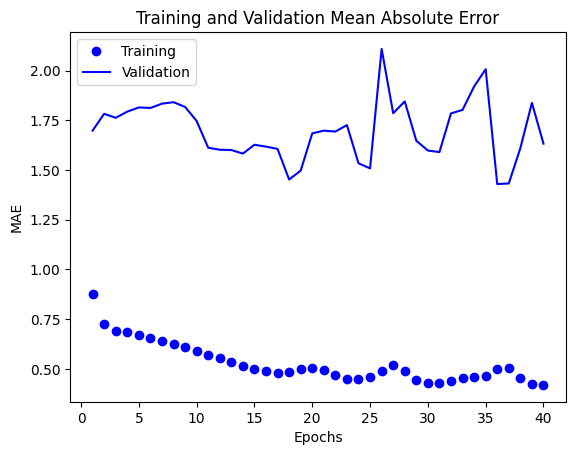

    elapsed time: 63025.4187 seconds


In [ ]:
# epochs to run for
epochs = 40

# timer
t = Timer()

# current model
model = augur_model()
# fit the model, validate and plot results
print(f'training model for {epochs}')
t.start()
mae, val_mae = run_model(model, train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=True, verbose=True)
t.stop()

In [ ]:
augur_mae = mae
augur_val_mae = val_mae

In [ ]:
# train final model

# model file name
model_name = nb_path + 'model_full_augur_colab.keras'

# timer
t = Timer()

# number of epochs to train for
epochs = 37

print(f'training final model {model_name} for {epochs} epochs')

print('  building model')
model = augur_model()

print('  training model')
t.start()
run_model(model, train_full_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

training final model model_full_augur.keras for 37 epochs
  building model
  training model
    elapsed time: 66046.5175 seconds
  evaluating model
672/672 [==============================] - 100s 149ms/step - loss: 3.1555 - mean_absolute_error: 1.6659
  mean absolute evaluation error is [3.1555373668670654, 1.6658642292022705]
  saving model


In [28]:
# epochs to run for
epochs = 40

# timer
t = Timer()

# current model
model = dan_zrimec_model()
# fit the model, validate and plot results
print(f'training model for {epochs}')
t.start()
mae, val_mae = run_model(model, train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=True, verbose=True)
t.stop()

training model for 40
Model: "FullModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs_1 (InputLayer)       [(None, None, 10)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, None, 280)            33880     ['inputs_1[0][0]']            
                                                                                                  
 batch_normalization (Batch  (None, None, 280)            1120      ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling1d (MaxPooling1  (None, None, 280)            0         

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/FullModel/max_pooling1d_1/MaxPool/MaxPoolGrad defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-28-df229a97a9e8>", line 12, in <cell line: 12>

  File "<ipython-input-9-67506938dbd4>", line 16, in run_model

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[64,896,2541,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/FullModel/max_pooling1d_1/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_394849]

In [ ]:
dz_mae = mae
dz_val_mae = val_mae

In [ ]:
# train final model

# model file name
model_name = nb_path + 'model_full_dz_colab.keras'

# timer
t = Timer()

# number of epochs to train for
epochs = 37

print(f'training final model {model_name} for {epochs} epochs')

print('  building model')
model = dan_zrimec_model()

print('  training model')
t.start()
run_model(model, train_full_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

## k-Fold Cross Validation

In [ ]:
num_splits = 5

### Augur Model

In [ ]:
%%time
# run k-fold cross validation

# epochs to run for
epochs = 100

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(augur_model(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

In [ ]:
# train final model

# model file name
model_name = 'model_augur.keras'

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

# number of epochs to train for
epochs = 40

print(f'training final model {model_name} for {epochs} epochs')

print('  creating training dataset')
t.start()
train_ds = create_dataset(X_train, y_train, batch_size=batch_size, sort=True)
t.stop()

print('  building model')
model = augur_model()

print('  training model')
t.start()
run_model(model, train_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

In [ ]:
%%time
# run k-fold cross validation

# epochs to run for
epochs = 100

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(dan_zrimec_model(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

In [ ]:
%%time
# run k-fold cross validation

# epochs to run for
epochs = 100

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(dan_zrimec_model2(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

# what are the steps?

- create ragged tensor from X_test
- create dataset from X_test and y_test

k-fold cross validation for the baseline neural network
- input is X_train, y_train
- using KFold this will be split in k folds
  - sort the trainin part
  - convert X to ragged tensor
  - create dataset
  - train
  - evaluate
- evaluate the cross fold performance
- rerun model with the whole dataset (test+val)
- save the model
```
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Fold {i}:")
    X_train_kf, X_test_kf, y_train_kf, y_test_kf = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
    # sort X_train_kf and y_train_kf
    # convert X_train_kf to ragged tensor
    # create dataset from X_train_kf and y_train_kf
    # do the training and evaluation
# evaluate the cross fold performance
```

train/val split for the full neural network -> separate jupyter notebook
- input X_train, y_train
- split the training test set again in train and val
- create ragged tensor from training X
- create dataset from training X and y
- train
- evaluate
- rerun the model with the whole dataset (test+val)
- save the model


what have both in common?
- data load and initial prep (up to the first split)
- model setup
- training setup
- visualisation
- evaluation -> this is just one command

helpful methods
- create_dataset(X, y, sort=False)
  input X and y, specify if the dataset should be sorted
  returns a TF dataset
- run_model(model, epochs, plot=True, plot_epoch_start=0)
- plot_loss()

- callbacks
    - earlystopping -> to limit training that doesn't progress, only for the tuner
    - backupandrestore -> for the full training as fault tolerance setup
    - modelcheckpoint -> to save the best model on the final train

In [ ]:
# split the train set again in train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1202)

In [ ]:
# find the first unique PTR value that is also in y_train
train_idx = 0
for i in range(len(y)):
    count = 0
    for l in range(len(y)):
        if i != l and y[i] == y[l]:
            count += 1
            continue
    if count == 0:
        for m in range(len(y_train)):
            if y[i] == y_train[m]:
                train_idx = m
                break
train_idx

In [ ]:
# get a sample
X_train[train_idx]

In [ ]:
# get the matching target
search_y = y_train[train_idx]
search_y

In [ ]:
# find the target value in the raw dataset
full_idx = 0
for i in range(len(y)):
    if y[i] == search_y:
        print(i)
        full_idx = i

In [ ]:
# compare if the raw dataset entry matches the subset entry
if X[full_idx].all() == X_train[train_idx].all():
    print('OK')

### Sort Training Data

In [ ]:
# build an inhomogenous numpy array from the training set
X_train = np.array(X_train, dtype=object)

In [ ]:
# build an array containing the sequence lengths
sequence_lengths = list(map(lambda x: len(x), X_train))

In [ ]:
# sort the array but only get the indices
sorted_indices = np.argsort(sequence_lengths)

In [ ]:
sorted_indices

In [ ]:
# now sort the X and y train arrays according to the sorted indicds
X_train = X_train[sorted_indices]
y_train = y_train[sorted_indices]

In [ ]:
# check if the previously found values still correlate
for i in range(len(y_train)):
    if y_train[i] == search_y:
        print(X_train[i])

### Ragged Tensor Tests

In [ ]:
# this does not work since the sequences are of different length
# X_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
%%time
X_train_tensor = tf.ragged.constant(X_train, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
X_val_tensor = tf.ragged.constant(X_val, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)

In [ ]:
X_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train))
X_val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val))

In [ ]:
X_train_dataset.element_spec

In [ ]:
X_val_dataset.element_spec

In [ ]:
# padded batches from ragged tensors are not supported (yet)
# it needs a work around creating a uniform tensor
# idea from : https://github.com/tensorflow/tensorflow/issues/39163
def reformat(data, label):
    return data, label

In [ ]:
X_train_dataset = X_train_dataset.map(reformat)
X_val_dataset = X_val_dataset.map(reformat)

In [ ]:
# shuffle the dataset (again) and create padded batches
batch_size = 64
X_train_dataset = X_train_dataset.padded_batch(batch_size)
X_val_dataset = X_val_dataset.shuffle(buffer_size=len(X_val), seed=1202).padded_batch(batch_size)

In [ ]:
# optinally repeat the dataset multiple times -> WHY?
# rep = 3
# X_train_dataset = X_train_dataset.repeat(rep)
# X_val_dataset = X_val_dataset.repeat(rep)

In [ ]:
datalen = []
ds_iterator = iter(X_train_dataset)
for data, label in ds_iterator:
    datalen.append(len(data[1]))

In [ ]:
datalen[:5]

In [ ]:
# testing if keras can use the dataset
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(None,4)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train_dataset, epochs=1)